# IMPORTS

In [1]:
import numpy as np
import pandas as pd
import os
from tabulate import tabulate
from pandarallel import pandarallel
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import pprint
import time
from scipy.sparse import csr_array
from sklearn.decomposition import LatentDirichletAllocation

# CONFIGURATION

In [2]:
# PREVIEW PHASE
PREVIEW_SIZE = 1000

# EXTRACT PHASE
CHUNK_SIZE = 100000
EXTRACT_PARQUET = True

ORIGINAL_DATASET_DIR = 'data/original/yelp_dataset/'
WORK_DATASET_DIR = 'data/work/yelp_dataset/'
PREFIX_YELP = 'yelp_academic_dataset_'

# FONCTIONS

In [3]:
def time_from(time_start):
    time_total = round(time.time() - time_start, 0)
    minutes = time_total // 60
    seconds = time_total - minutes * 60
    return f'{minutes:.0f}mn {seconds:.0f}s'
    
def list_files(dir, extension='json', print_result = True):
    paths = {(file.split('.')[0]).split(PREFIX_YELP)[1]: dir + file for file in os.listdir(dir) if file.endswith('.' + extension)}
    if print_result:
        files = [[os.path.basename(paths[name]), file_size(paths[name])] for name in paths]
        print(tabulate(files, headers=['Name', 'Size']))
    return paths

def file_size(path, unit='Gb', precision=2, only_value = False):
    exp = 3
    if (unit=='ko'):
        exp = 1
    elif (unit == 'Mb'):
        exp = 2
    else:
        exp = 3
        unit = 'Gb'

    value = round((os.path.getsize(path)/(1024**exp)), precision)
    if only_value:
        return value
    else:
        return str(value) + unit

def preview_dataset(path):
    df = pd.read_json(path, lines=True, nrows=PREVIEW_SIZE)
    display(df.sample(5))
    display(df.dtypes)

    return df    

def get_stop_words(reviews: pd.DataFrame, drop_words_frequency_under = 1, drop_most_frequent_words = 0, verbose = 0):
    words = {}
    for index in reviews.index:
        for token in reviews.loc[index, 'tokens']:
            if token not in words:
                words[token] = 1
            else:
                words[token] = words[token] + 1

    words = dict(sorted(words.items(), key=lambda item: item[1]))

    # Remove english stop word
    english_sw = stopwords.words('english')
    words_wo_sw = {token:words[token] for counter, token in enumerate(words) if token not in english_sw}

    # Drop most frequent
    most_frequent = [[token, words_wo_sw[token]] for counter,token in enumerate(words_wo_sw) if counter > len(words_wo_sw) - drop_most_frequent_words - 1]
    if verbose > 1 : 
        print(f'Les {drop_most_frequent_words} mots les plus fréquents:')
        print(tabulate(most_frequent[::-1], headers=['mot', 'Nombre d\'apparitions']))
        print('')

    # Drop frequency under
    frequency_under = [token for token, count in words_wo_sw.items() if count < drop_words_frequency_under]
    if verbose > 1:
        print(f'{len(frequency_under)} mots apparaissent moins de {drop_words_frequency_under} fois:')
        np_treshold = np.get_printoptions()['threshold']
        np.set_printoptions(threshold=20)
        print(np.array(frequency_under))
        np.set_printoptions(threshold=np_treshold)
        print('')

    sw = list(set(stopwords.words('english') + list(np.array(most_frequent).T[0]) + frequency_under))

    return sw, len(words)      

def drop_words(tokens, words):
    return [token for token in tokens if token not in words]

def preprocess_text(text):
    # normalization
    text = text.lower().strip()

    return text 

def tokenize(text):
    from nltk import RegexpTokenizer
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer

    # Tokenization
    tokenizer = RegexpTokenizer(r'(?u)\b\w\w+\b')
    tokens = tokenizer.tokenize(text)

    # Lematization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, pos='a') for word in tokens]
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
    tokens = [lemmatizer.lemmatize(word, pos='n') for word in tokens]

    return tokens

def word_cloud(text):
    wordcloud = WordCloud(background_color = 'white', max_words = 50).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show();

def get_vocabulary_matrix(reviews: pd.DataFrame):
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}
    for review in list(reviews['tokens']):
        for token in review:
            index = vocabulary.setdefault(token, len(vocabulary))
            indices.append(index)
            data.append(1)
        indptr.append(len(indices))
    csr = csr_array((data, indices, indptr), dtype=int).toarray()

    return csr

def lda(reviews: pd.DataFrame, n_topics = 10, n_top_words = 10, verbose = 0):
    if verbose > 1: print('  - Creation de la matrice du vocabulaire')
    vocabulary_matrix = get_vocabulary_matrix(reviews)

    # Topics from LDA
    if verbose > 1: print('  - Modélisation LDA')
    model_lda = LatentDirichletAllocation(
            n_components=n_topics, 
            max_iter=5, 
            learning_method='online', 
            learning_offset=50.,
            random_state=0,
            n_jobs=-1)
    model_lda.fit(vocabulary_matrix)

    if verbose > 1: print('  - Affichage des topics\n')
    topics = []
    feature_names = list(set(reviews['tokens'].sum()))
    for topic_idx, topic in enumerate(model_lda.components_):
        features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append([topic_idx, ', '.join(features)])
    
    if verbose > 0: print(tabulate(topics, headers=['Topic n°', 'Categories']))

    return topics

# PREVISUALISATION DES DATASETS

In [4]:
files = list_files(ORIGINAL_DATASET_DIR)
print('')
print(tabulate([[k,v] for k,v in files.items()]))

Name                                 Size
-----------------------------------  ------
yelp_academic_dataset_business.json  0.11Gb
yelp_academic_dataset_checkin.json   0.27Gb
yelp_academic_dataset_review.json    4.98Gb
yelp_academic_dataset_tip.json       0.17Gb
yelp_academic_dataset_user.json      3.13Gb

--------  --------------------------------------------------------------
business  data/original/yelp_dataset/yelp_academic_dataset_business.json
checkin   data/original/yelp_dataset/yelp_academic_dataset_checkin.json
review    data/original/yelp_dataset/yelp_academic_dataset_review.json
tip       data/original/yelp_dataset/yelp_academic_dataset_tip.json
user      data/original/yelp_dataset/yelp_academic_dataset_user.json
--------  --------------------------------------------------------------


In [5]:
preview_dfs = {}
for name in files:
    print(f'PREVIEW {name}\n=====================\n')
    preview_dfs[name] = preview_dataset(files[name])
    print('')

PREVIEW business



,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
480,g736EKijhJTrQbqoQAo9Tw,The Pet Trailer Mobile Grooming,6153 103rd Ave N,Pinellas Park,FL,33782,27.865613,-82.719991,5.0,6,0,None,"Pet Services, Pet Groomers, Pet Sitting, Pets","{'Monday': '8:0-18:0', 'Tuesday': '8:0-18:0', ..."
707,1o_M5JdOkJJFNj1rIDIlng,The Juice Pod,11 W Woodland Ave,Springfield,PA,19064,39.924933,-75.340216,4.0,19,1,"{'WiFi': 'u'free'', 'BusinessAcceptsCreditCard...","Food, Juice Bars & Smoothies","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ..."
688,kfGz2E7Y5FLXJyiKbQYfZg,The Irish Times,629 S 2nd St,Philadelphia,PA,19147,39.940374,-75.145611,3.5,44,0,"{'GoodForKids': 'True', 'BusinessAcceptsCredit...","Nightlife, Bars, Beer, Wine & Spirits, Pubs, I...","{'Monday': '12:0-2:0', 'Tuesday': '12:0-2:0', ..."
127,BVo_36t3z7vfXp3XGgJkOg,Sears Auto Center,4400 Veterans Memorial Blvd,Metairie,LA,70006,30.004280,-90.181322,1.5,37,0,{'BusinessAcceptsCreditCards': 'True'},"Tires, Auto Repair, Oil Change Stations, Autom...","{'Monday': '8:0-19:0', 'Tuesday': '8:0-19:0', ..."
285,vSE6lkp5FBcttPxEbQ9XCw,Kim Kelly & Co Clinical Skin Care,"252 W Swamp Rd, Ste 56",Doylestown,PA,18901,40.331127,-75.137134,5.0,7,1,"{'ByAppointmentOnly': 'True', 'BusinessAccepts...","Health & Medical, Medical Spas, Beauty & Spas,...","{'Monday': '10:0-17:0', 'Tuesday': '10:0-17:0'..."


business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
attributes       object
categories       object
hours            object
dtype: object


PREVIEW checkin



,business_id,date
66,-0kH3RmIVq-OhpuWAuU59w,"2010-10-04 20:20:30, 2010-12-08 23:56:36, 2011..."
121,-2Tm0VU-tcatBp-SCZsuZg,"2011-03-23 21:54:38, 2011-10-25 15:50:15, 2012..."
438,-C0I0bSrWz2pO_FHhvt4uQ,"2013-03-31 18:40:22, 2013-04-14 21:25:15, 2013..."
386,-AanHawaDlzWHQjrqRRWig,"2010-07-15 16:22:18, 2010-09-23 16:05:09, 2011..."
848,-PKjA_-bWOD0zj2SPH3ZLA,"2010-10-22 22:32:11, 2010-11-07 23:01:19, 2010..."


business_id    object
date           object
dtype: object


PREVIEW review



,review_id,user_id,business_id,stars,useful,funny,cool,text,date
447,PRAsITyAFOrVM_YcbJA5QA,gv0coNUFY-fibRwP8IKqPA,qdL-EbgoA7Gq_2u4e4YvLw,3,2,0,0,Harry's blue bell is a nice spot. We stopped a...,2018-03-24 02:08:27
844,Ifa0h4i6zA7f0t-ZFdL8tw,1Y38tVMSPH8jwIGw_y_E3g,W4ZEKkva9HpAdZG88juwyQ,5,1,0,0,This place was definitely the best dining expe...,2014-01-17 03:06:58
271,B_O-c_YGiNRXFk3yGzYhyQ,LNHVcCbz5L5IfzR6aI67Dw,dxNmbVCP-HGrDkPi4lqKDw,1,0,0,0,Called in to get service information on my 201...,2014-12-18 19:55:37
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
302,Vb_BsacvTvDXEZiWVE6Thg,Eux0pgbEJeeVGaJiTbJeoA,O0k_pEr2UR6iEX2nv2Bbpg,5,0,0,0,Love this place. Best kept secret in Creve C...,2018-09-14 03:10:54


review_id              object
user_id                object
business_id            object
stars                   int64
useful                  int64
funny                   int64
cool                    int64
text                   object
date           datetime64[ns]
dtype: object


PREVIEW tip



,user_id,business_id,text,date,compliment_count
207,0L_WSBXdLgTneHyDRlZMgA,vh6YOciEM3M4zi2FGp-b5Q,Best sushi and Asian food that I've had in STL!,2014-08-28 22:12:43,0
915,MlwC51xriqAqrE-1SL9PoA,2CDI713ATuxHfnB5b-sBdw,I came back. I got the Rutabega Fondue. It was...,2016-05-06 12:56:46,0
724,AkZXxm6Y5C-KXu52B2Tklg,eZhg3r6BVhoSwmBWVEmeuA,I eat very spicy food but I still find these h...,2011-07-15 00:22:27,0
740,pNaIPmmHAAgiXNvMDPnPoA,hUmHwBQtGg0iH-PZakQJDw,"Great service, food, and cocktails. Definitel...",2017-09-21 11:12:34,0
687,HjCfLjX6pbL-RSVuxRnHGA,eSyQd3F9v8732BT61CUxaA,Apple spiced cheer is awesome for the 2016 hol...,2016-11-15 02:02:10,0


user_id                     object
business_id                 object
text                        object
date                datetime64[ns]
compliment_count             int64
dtype: object


PREVIEW user



,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
835,Q97QCDBnJWDiFUhg8uJcjQ,Charles,472,2009-05-26 07:09:02,732,117,153,,"0rskTMzK-72RAEnhgEhBUA, 9dtkPS9aKYNGzBZb76BFvA...",30,...,4,2,0,2,11,16,3,3,6,1
197,lsCWo9DwJJ7tCRBHNjTsYA,Joy,60,2008-11-18 17:26:46,74,13,27,,"cNTkbrIgGh6hb85Z40cLTA, uOQ-9KLCRqgG_6BecW0Fdg...",1,...,1,0,0,0,0,1,4,4,1,0
659,JXbz8URET4T6SWVrDmKWTA,Janelle,417,2007-01-26 19:22:50,1028,175,309,"2007,2008","y8aWXOimQ9ZgUgZ6q--nCQ, tBDuQRcieQy3FF70UYQpAg...",26,...,6,1,0,2,21,16,21,21,4,6
879,1hwTDYX9S0yyC6qdkfTmLA,Brian,12,2011-03-28 18:38:33,9,8,2,,"0Ear9GEUEvSceG6uDsmyfg, RR7OazBiR549ODWPqjqRyA...",0,...,0,0,0,0,0,0,0,0,0,0
337,i5Cm53q0pmklQsX8soi3tw,Jocelyn,853,2010-07-08 06:11:31,1266,364,521,"2013,2014,2015,2016,2017,2018,2019,20,20,2021","ithIcJE0V8nv4utlzi6T2Q, mw46pGO6Qf8HqtzMA_M9Sg...",57,...,5,2,2,1,14,19,25,25,16,6


user_id                object
name                   object
review_count            int64
yelping_since          object
useful                  int64
funny                   int64
cool                    int64
elite                  object
friends                object
fans                    int64
average_stars         float64
compliment_hot          int64
compliment_more         int64
compliment_profile      int64
compliment_cute         int64
compliment_list         int64
compliment_note         int64
compliment_plain        int64
compliment_cool         int64
compliment_funny        int64
compliment_writer       int64
compliment_photos       int64
dtype: object

<Axes: xlabel='stars'>

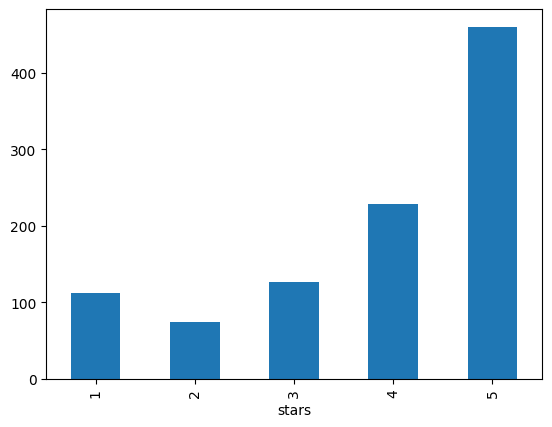

In [6]:
preview_dfs['review']['stars'].value_counts().sort_index().plot.bar()

In [7]:
preview_dfs['business']['categories'].unique()[0:20]

array(['Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists',
       'Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services',
       'Department Stores, Shopping, Fashion, Home & Garden, Electronics, Furniture Stores',
       'Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries',
       'Brewpubs, Breweries, Food',
       'Burgers, Fast Food, Sandwiches, Food, Ice Cream & Frozen Yogurt, Restaurants',
       'Sporting Goods, Fashion, Shoe Stores, Shopping, Sports Wear, Accessories',
       'Synagogues, Religious Organizations',
       'Pubs, Restaurants, Italian, Bars, American (Traditional), Nightlife, Greek',
       'Ice Cream & Frozen Yogurt, Fast Food, Burgers, Restaurants, Food',
       'Department Stores, Shopping, Fashion',
       'Vietnamese, Food, Restaurants, Food Trucks',
       'American (Traditional), Restaurants, Diners, Breakfast & Brunch',
       'General Dentistry, Dentists, Health & Medic

In [8]:
review = preview_dfs['review']
for star in range(1,6):
    print(f'Note = {star}:\n=========\n')
    for index in review[review['stars']==star].sample(4, random_state=0).index:
        stars, text = review.loc[index, ['stars', 'text']].values
        print(f'{text}\n\n')

Note = 1:

They have the WORST service advisors! Used to be good before Kelly and her team left. Unfortunately, it's convenient to work if I need oil change before I can make it to another Honda dealer.


It is unfortunate that with such a unique location and such a brand and product offering this specific store offers such lousy service. The wait is endless, no one is available to help and at Christmas time getting a gift wrap is act of God that requires endless wait. I bought gifts and knew that the wait for wrapping would be long SO I even left my items at the store to be gift wrapped at their leisure. They were not even moved from the counter where I bought them when I returned almost two hours later ready for pick up. This was a gift that needed to be given and The staff COMPLETELY "dropped the ball" on my time constraints! 

I love their stuff, but today was my last shopping experience at this location: couldn't get a gift wrapped after being assured that it could be done in a ti

<Axes: xlabel='class'>

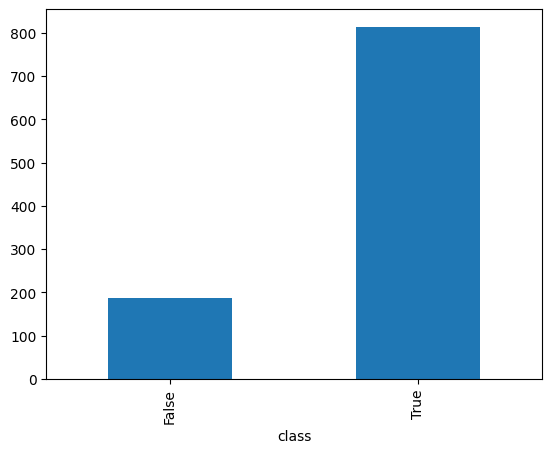

In [10]:
preview_dfs['review']['class'] = preview_dfs['review']['stars'] > 2
preview_dfs['review']['class'].value_counts().sort_index().plot.bar()

# EXTRACTION GOOD/BAD REVIEWS DES RESTAURANTS

## CATEGORIES DE BUSINESS

In [11]:
business = pd.read_json(ORIGINAL_DATASET_DIR + PREFIX_YELP + 'business.json', lines=True)
business['_cats'] = business['categories'].apply(lambda x: [cat.strip() for cat in x.split(',')] if x else [])
business['_cats'].sample(5)

113294        [Restaurants, Pizza, Latin American, Italian]
55329     [Event Planning & Services, Party & Event Plan...
14869                         [Restaurants, American (New)]
55820     [Nightlife, Chicken Wings, Restaurants, Bars, ...
40005     [Accessories, Shopping, Fashion, Women's Cloth...
Name: _cats, dtype: object

In [12]:
categories = set()
for index in business.index:
    categories.update(business.loc[index, '_cats'])

In [13]:
[categorie for categorie in categories if 'restaurant' in categorie.lower()]

['Restaurants', 'Pop-Up Restaurants', 'Restaurant Supplies']

In [14]:
[categorie for categorie in categories if 'food' in categorie.lower()]

['Food Delivery Services',
 'Specialty Food',
 'Food Trucks',
 'Food Banks',
 'Soul Food',
 'Live/Raw Food',
 'Fast Food',
 'Ethnic Food',
 'Seafood',
 'Food',
 'Comfort Food',
 'Imported Food',
 'Do-It-Yourself Food',
 'Seafood Markets',
 'Food Tours',
 'Food Court',
 'Food Stands']

## REDUCTION DU DATAFRAME REVIEW ET SAUVEGARDE

- par chunk de 100000
- Filtrage des reviews sur categorie "restaurants"
- Séparation en bad/good reviews (bad <= stars = 3 < good)
- Ne garder que text et séparer en 2 fichiers good/bad news

In [15]:
restaurants_ids = business[~business['categories'].isna() & business['categories'].str.contains('Restaurants')]['business_id'].to_list()
restaurants_ids[0:10]

['MTSW4McQd7CbVtyjqoe9mw',
 'CF33F8-E6oudUQ46HnavjQ',
 'k0hlBqXX-Bt0vf1op7Jr1w',
 'bBDDEgkFA1Otx9Lfe7BZUQ',
 'eEOYSgkmpB90uNA7lDOMRA',
 'il_Ro8jwPlHresjw9EGmBg',
 '0bPLkL0QhhPO5kt1_EXmNQ',
 'MUTTqe8uqyMdBl186RmNeA',
 'ROeacJQwBeh05Rqg7F6TCg',
 'WKMJwqnfZKsAae75RMP6jA']

In [16]:
append = False
good_reviews_file = WORK_DATASET_DIR + 'good_reviews.parquet'
bad_reviews_file = WORK_DATASET_DIR + 'bad_reviews.parquet'

if EXTRACT_PARQUET:
    for chunk in pd.read_json(ORIGINAL_DATASET_DIR + PREFIX_YELP + 'review.json', lines=True, chunksize=100000):
        restaurant_reviews = chunk[chunk['business_id'].isin(restaurants_ids)].copy()
        restaurant_reviews['class'] = restaurant_reviews['stars'] > 2
        restaurant_reviews = restaurant_reviews.loc[:, ['text', 'class']]
    
        good_reviews = pd.DataFrame(restaurant_reviews[restaurant_reviews['class'] == True]['text'])
        bad_reviews = pd.DataFrame(restaurant_reviews[restaurant_reviews['class'] == False]['text'])
    
        good_reviews.to_parquet(good_reviews_file, engine='fastparquet', append=append)
        bad_reviews.to_parquet(bad_reviews_file, engine='fastparquet', append=append)
        append = True

# TOKENIZATION ET ANALYSE DES BAD REVIEWS 

In [18]:
def find_topics(reviews_file, drop_words_frequency_under = 4, drop_most_frequent_words = 100, n_topics = 10, n_topic_top_words=10, sample_size = None, verbose = 0):

    # load dataframe and display head
    if verbose > 0: print('Chargement du dataset\n=================\n')
    reviews = pd.read_parquet(reviews_file)

    if verbose > 0 : print(f'Il y a {reviews.shape[0]} enregistrements')
    
    if sample_size:
        reviews = reviews.sample(sample_size, random_state=0)

    if verbose > 1: display(reviews.sample(5, random_state=0))
    
    # Initialize paralellize and sampling
    pandarallel.initialize(progress_bar=(verbose > 0), verbose=False)
    
    # Preprocess
    if verbose > 0: print('\nPreprocess\n=================\n')
    reviews['text'] = reviews['text'].parallel_apply(preprocess_text)

    # Preprocess (tokenize, lemmatization)
    if verbose > 0: print('\nTokenize\n=================\n')
    reviews['tokens'] = reviews['text'].parallel_apply(tokenize)
    reviews.drop(columns=['text'], inplace=True)
    
    # Remove words by frequency
    if verbose > 0:
        print(f'\nSuppression par fréquence\n=================')
        print(f'  - {drop_most_frequent_words} mots les plus fréquents')
        print(f'  - apparaisant moins de {drop_words_frequency_under} fois\n')

    stop_words, nb_words_original = get_stop_words(reviews, drop_words_frequency_under, drop_most_frequent_words, verbose)
    reviews['tokens'] = reviews['tokens'].parallel_apply(drop_words, args=(stop_words,))
    reviews['text_len'] = reviews['tokens'].str.join(' ').str.len()
    
    if verbose > 0:
        print('')
        tokens_infos = [
            ['Nombre de tokens unique initial dans le dataframe', nb_words_original],
            ['Nombre de stopwords', len(stop_words)],
            ['Nombre de tokens unique restant dans le dataframe', len(set(reviews['tokens'].sum()))]
        ]
        print(tabulate(tokens_infos))

    if verbose > 1:
        # View result sample
        print('\nEchantillon du resultat\n=================\n')
        display(reviews.sample(5, random_state=0))
    
        # Calc and view text lengths
        print('\nAnalyse des longeurs de text\n=================\n')
        reviews.boxplot(column='text_len', showfliers=True, vert=False)
        plt.show()

    # Duplicates
    nb_duplicated = reviews.duplicated(subset='tokens').sum()
    reviews.drop_duplicates(subset='tokens', keep='first', inplace=True)

    if verbose > 0:
        print(f'Nombre de textes dupliqués supprimés: {nb_duplicated}')
        
        # Text length
        total_text_len = reviews['text_len'].sum()
        print(f'Longeur total du texte dans le dataframe: {total_text_len}')
    
        print('')

    if verbose > 1:
        # Visualisation Word clound on sample
        cloud_sample_size = min(reviews.shape[0], 1000)
        print(f'\nVisualisation du nuage de mot d\'un échantillon de {cloud_sample_size} lignes\n=================\n')
        sample_text = ' '.join(reviews.sample(cloud_sample_size, random_state=0)['tokens'].str.join(' ').values)
        word_cloud(text=sample_text)
        print('')


    if verbose > 0: print('\nRecherche des topics\n=================\n')
    # Create counter matrix from vocabulary
    topics = lda(reviews, n_topics, n_topic_top_words, verbose)

    
    return topics

Chargement du dataset

Il y a 971671 enregistrements


,text
index,
5029786,"Super nice employees and service , but dirty! ..."
5651283,The buffet is way over priced for the quality ...
1369777,I opted to bring my family members who are her...
1855284,So I order a lobster fried rice right thinking...
146886,This used to be my favorite restaurant in Tucs...



Preprocess




Tokenize




Suppression par fréquence
  - 20 mots les plus fréquents
  - apparaisant moins de 2 fois

Les 20 mots les plus fréquents:
mot        Nombre d'apparitions
-------  ----------------------
food                       3596
order                      3532
get                        2912
go                         2857
good                       2476
place                      2335
time                       2092
come                       2069
service                    1806
like                       1777
say                        1765
one                        1704
u                          1567
back                       1558
take                       1509
would                      1487
ask                        1359
wait                       1358
table                      1253
make                       1250

4782 mots apparaissent moins de 2 fois:
['craftsmanship' 'discriminatory' 'audit' ... '43pm' 'unmemorable'
 'foolishly']




-------------------------------------------------  -----
Nombre de tokens unique initial dans le dataframe  11246
Nombre de stopwords                                 4981
Nombre de tokens unique restant dans le dataframe   6315
-------------------------------------------------  -----

Echantillon du resultat



,tokens,text_len
index,,
5029786,"[super, nice, employee, dirty, worth, mile]",36
5651283,"[buffet, way, price, quality, serve, chaat, bu...",136
1369777,"[opt, bring, family, member, visit, restaurant...",298
1855284,"[lobster, fry, rice, right, think, actual, lob...",288
146886,"[use, favorite, restaurant, tucson, dinner, la...",115



Analyse des longeurs de text



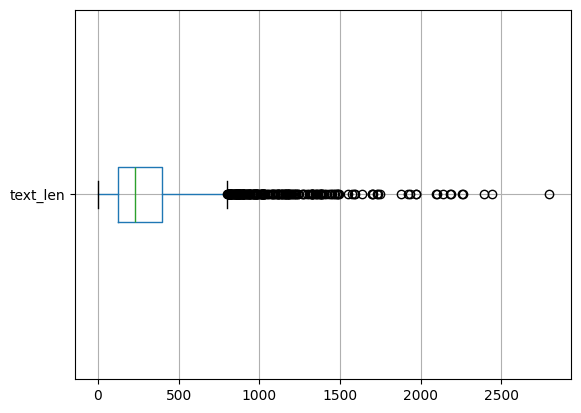

Nombre de textes dupliqués supprimés: 2
Longeur total du texte dans le dataframe: 1238303


Visualisation du nuage de mot d'un échantillon de 1000 lignes



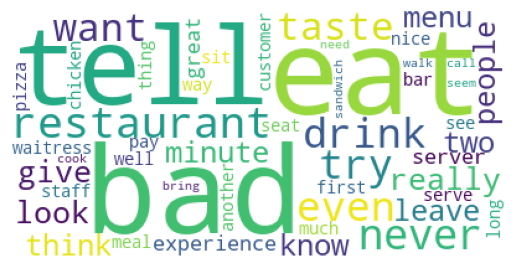



Recherche des topics

  - Creation de la matrice du vocabulaire
  - Modélisation LDA
  - Affichage des topics

  Topic n°  Categories
----------  ------------------------------------------
         0  competent, potatoe, harry, greedy, theater
         1  rancid, royal, stalk, receipt, danny
         2  slushies, throw, overhaul, intention, mind
         3  uber, adorn, film, douche, merely
         4  sonic, current, solution, progress, unless


In [19]:
topics = find_topics(reviews_file=bad_reviews_file,
                     drop_words_frequency_under=2,
                     drop_most_frequent_words=20,
                     n_topics=5, 
                     n_topic_top_words=5,
                     sample_size = 4000,
                     verbose=3)

In [41]:
import platform
from IPython.display import display, clear_output


topics_grid = []
start = time.time()
LINE_UP = '\033[1A'
LINE_CLEAR = '\x1b[2K'

drop_words_frequency_under_range = range(2,11,3)
drop_most_frequent_words_range = range(10, 101, 25)
n_topics_range = range(3,8,2)

total_loops = len(drop_words_frequency_under_range)*len(drop_most_frequent_words_range) * len(n_topics_range)
current_loop = 1
for drop_words_frequency_under in drop_words_frequency_under_range:
    for drop_most_frequent_words in drop_most_frequent_words_range:
        for n_topics in n_topics_range:
            print(f'Recherche {current_loop}/{total_loops}')
            print(f'Temps écoulé {time_from(start)}')
            print(f'Parametres:')
            hyper_params = [['Fréquence minimal d\'un mot', drop_words_frequency_under], ['Top des mots les plus fréquent supprimés', drop_most_frequent_words], ['Nombre de topics', n_topics]]
            print(tabulate(hyper_params,))
            topics = find_topics(reviews_file=bad_reviews_file,
                                              drop_words_frequency_under=drop_words_frequency_under,
                                              drop_most_frequent_words=drop_most_frequent_words,
                                              n_topics=n_topics, 
                                              n_topic_top_words=5,
                                              sample_size = 100,
                                              verbose=0)
            current_loop = current_loop + 1
            clear_output()
            topics_grid.append({'params': 'drop_words_frequency_under\ndrop_most_frequent_words' ,
                                'value': str(drop_words_frequency_under) + '\n' + str(drop_most_frequent_words),
                                'topics': '\n'.join([str(topic[0]) + ' : ' + topic[1] for topic in topics])
                               })

print(f'{total_loops} boucles éxécutées en {time_from(start)}\n\n')
print(tabulate(topics_grid,  headers="keys", tablefmt="grid"))
        

36 boucles éxécutées en 8mn 59s


+----------------------------+---------+-----------------------------------------------------+
| params                     | value   | topics                                              |
+============================+=========+=====================================================+
| drop_words_frequency_under | 2       | 0 : poor, someone, irritate, friend, build          |
| drop_most_frequent_words   | 10      | 1 : sauce, inside, sunday, well, busy               |
|                            |         | 2 : mess, literally, girl, busy, mediocre           |
+----------------------------+---------+-----------------------------------------------------+
| drop_words_frequency_under | 2       | 0 : poor, another, southern, sit, build             |
| drop_most_frequent_words   | 10      | 1 : inside, mediocre, sunday, replacement, probably |
|                            |         | 2 : girl, literally, mess, mediocre, try            |
|               